# Tutorial

A tutorial on how to derive Oh et. al.'s plasma signature of cognitive impairment (CI) from your SomaScan plasma proteomics data. 


In [1]:
import synapsesignature
import json
from importlib import resources
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Load plasma signature weights
Download supplementary table 11 and read in the dataframe. This file contains all information needed to derive the signature.

In [2]:
#replace file path with your own for downloaded ST11
weightsdf = pd.read_csv(resources.open_text("synapsesignature.data", "Ohetal_ST11.csv"))
weightsdf


,Symbol_unique,SeqId,coef,abs coef,intercept,mean,std_dev,assay,5k_to_7k_scale,11k_to_7k_scale
0,PDGFRA,10366-11,0.008028,0.008028,0.817268,3.083279,0.174205,5k,0.767,NaN
1,SCARA5,10419-1,0.012099,0.012099,0.817268,3.724732,0.146852,5k,0.787,NaN
2,KIR2DS2,10428-1,0.003254,0.003254,0.817268,3.176708,0.231993,5k,0.654,NaN
3,RPN1.1,10490-3,-0.003532,0.003532,0.817268,3.505364,0.136095,5k,0.862,NaN
4,PTGDS,10514-5,0.062116,0.062116,0.817268,4.335063,0.139969,5k,0.719,NaN
...,...,...,...,...,...,...,...,...,...,...
526,TIGIT.2,9638-2,-0.000895,0.000895,0.818120,1.947232,0.188881,7k,NaN,0.987
527,TAGLN.2,9756-6,0.005184,0.005184,0.818120,3.422987,0.155943,7k,NaN,1.142
528,SEMA4B,9805-51,-0.015607,0.015607,0.818120,3.033883,0.125209,7k,NaN,1.087
529,KRT1,9931-20,0.020107,0.020107,0.818120,3.175315,0.128921,7k,NaN,0.895


## Load raw proteomics data

Somalogic provides two results data files:
- ANML normalized (filename ends with ".qcCheck.anmlSMP.adat")
- not ANML normalized (filename ends with ".qcCheck.adat")


The signature was trained on ANML normalized data, so we recommend applying it to ANML normalized data for consistency. It should still apply well to non-ANML normalized data.


In [3]:
#mock data with age, sex, cognitive impairment, and protein levels (SeqId as column names, v4.1 assay)
df = pd.read_csv(resources.open_text("synapsesignature.data", "mockdata.csv")).set_index("ID")
df


,Age,Sex,CI,10000-28,10001-7,10003-15,10006-25,10008-43,10010-10,10011-65,...,9984-12,9986-14,9987-30,9989-12,9991-112,9993-11,9994-217,9995-6,9997-12,9999-1
ID,,,,,,,,,,,,,,,,,,,,,
SID1,89,M,1.0,749.0,280.0,258.0,567.0,506.0,383.0,2149.0,...,637.0,2862.0,603.0,334.0,917.0,1630.0,9843.0,704.0,4189.0,990.0
SID2,80,F,0.0,655.0,79264.0,115.0,594.0,397.0,334.0,2536.0,...,730.0,4505.0,432.0,423.0,476.0,2039.0,1653.0,1433.0,6182.0,754.0
SID3,80,F,0.0,630.0,389.0,136.0,615.0,276.0,341.0,1903.0,...,343.0,3631.0,625.0,425.0,972.0,1793.0,1489.0,1329.0,4426.0,1357.0
SID4,76,F,0.0,968.0,487.0,258.0,836.0,295.0,445.0,1812.0,...,597.0,1851.0,905.0,442.0,345.0,3796.0,2685.0,3000.0,6749.0,2510.0
SID5,96,M,1.0,592.0,637.0,185.0,373.0,411.0,368.0,2374.0,...,476.0,7274.0,635.0,640.0,450.0,1828.0,1951.0,1192.0,4649.0,894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SID196,85,M,0.0,826.0,314.0,208.0,613.0,484.0,496.0,2613.0,...,607.0,5351.0,470.0,452.0,1761.0,1310.0,1461.0,7409.0,7360.0,824.0
SID197,82,F,1.0,464.0,245.0,127.0,320.0,679.0,362.0,1844.0,...,743.0,8092.0,651.0,381.0,508.0,1322.0,1503.0,2144.0,16078.0,1735.0
SID198,89,M,3.0,402.0,313.0,193.0,952.0,451.0,252.0,1577.0,...,545.0,8337.0,439.0,545.0,312.0,987.0,2601.0,1133.0,8834.0,1448.0


In [4]:
#separate into metadata and protein level data
md = df.iloc[:,:3]
dfprot = df.iloc[:,3:]
dfprot


,10000-28,10001-7,10003-15,10006-25,10008-43,10010-10,10011-65,10012-5,10014-31,10015-119,...,9984-12,9986-14,9987-30,9989-12,9991-112,9993-11,9994-217,9995-6,9997-12,9999-1
ID,,,,,,,,,,,,,,,,,,,,,
SID1,749.0,280.0,258.0,567.0,506.0,383.0,2149.0,1755.0,751.0,578.0,...,637.0,2862.0,603.0,334.0,917.0,1630.0,9843.0,704.0,4189.0,990.0
SID2,655.0,79264.0,115.0,594.0,397.0,334.0,2536.0,1867.0,1375.0,904.0,...,730.0,4505.0,432.0,423.0,476.0,2039.0,1653.0,1433.0,6182.0,754.0
SID3,630.0,389.0,136.0,615.0,276.0,341.0,1903.0,1378.0,796.0,540.0,...,343.0,3631.0,625.0,425.0,972.0,1793.0,1489.0,1329.0,4426.0,1357.0
SID4,968.0,487.0,258.0,836.0,295.0,445.0,1812.0,1799.0,875.0,1053.0,...,597.0,1851.0,905.0,442.0,345.0,3796.0,2685.0,3000.0,6749.0,2510.0
SID5,592.0,637.0,185.0,373.0,411.0,368.0,2374.0,1988.0,817.0,583.0,...,476.0,7274.0,635.0,640.0,450.0,1828.0,1951.0,1192.0,4649.0,894.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SID196,826.0,314.0,208.0,613.0,484.0,496.0,2613.0,1836.0,4331.0,685.0,...,607.0,5351.0,470.0,452.0,1761.0,1310.0,1461.0,7409.0,7360.0,824.0
SID197,464.0,245.0,127.0,320.0,679.0,362.0,1844.0,1218.0,576.0,829.0,...,743.0,8092.0,651.0,381.0,508.0,1322.0,1503.0,2144.0,16078.0,1735.0
SID198,402.0,313.0,193.0,952.0,451.0,252.0,1577.0,1332.0,670.0,480.0,...,545.0,8337.0,439.0,545.0,312.0,987.0,2601.0,1133.0,8834.0,1448.0


## Scale to v4.1 (7k) assay space

If your SomaScan data is v4 (5k proteins) or v11 (11k proteins), you will need to normalize the protein levels to v4.1 (7k proteins) assay space. Normalization is performed by simply multiplying protein levels with protein-specific scale factors. An example is shown for 5k data below. 

In [5]:
#subset to proteins in the 5k model, make dictionary of protein:scale factor
weightsdf_5k = weightsdf.loc[weightsdf.assay=='5k']
scale_5k = dict(zip(weightsdf_5k.SeqId, weightsdf_5k['5k_to_7k_scale']))

#apply scale factors per protein
dfprot_5k = dfprot[weightsdf_5k.SeqId]
for pr in dfprot_5k.columns:
    dfprot_5k[pr] = dfprot_5k[pr]*scale_5k[pr]
dfprot_5k


/var/folders/jr/h76lm1f121b1h_l80lh_1kyh0000gp/T/ipykernel_7227/2732217813.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfprot_5k[pr] = dfprot_5k[pr]*scale_5k[pr]


,10366-11,10419-1,10428-1,10490-3,10514-5,10521-10,10558-26,10603-1,10615-18,10756-34,...,9361-7,9409-11,9468-8,9470-15,9484-75,9599-6,9638-2,9805-51,9931-20,9970-7
ID,,,,,,,,,,,,,,,,,,,,,
SID1,1313.871,4278.132,1288.380,2317.918,12183.455,788.705,2890.811,1327.26,5649.270,373.70,...,622.518,14482.240,4611.514,671.576,141.085,1299.625,83.986,863.051,842.270,750.336
SID2,1102.946,3321.140,517.968,2066.214,15732.439,704.825,1360.282,677.82,815.670,526.88,...,1305.414,16047.865,3196.132,364.744,107.793,1299.625,35.137,1060.852,1163.058,511.948
SID3,892.021,2915.835,873.090,1962.774,16084.749,772.395,4479.783,883.74,1091.535,856.18,...,732.864,47833.810,3510.382,1021.080,141.694,1565.100,71.988,1110.524,703.638,388.846
SID4,828.360,2972.499,906.444,2361.018,19477.710,467.165,2601.984,660.66,600.225,352.98,...,1115.952,10394.080,3330.212,496.824,132.153,958.300,56.562,953.525,668.174,845.105
SID5,727.883,3473.818,201.432,2138.622,20810.017,1015.880,3266.879,471.90,1103.460,418.10,...,464.286,21577.235,4958.446,590.296,106.575,1554.925,98.555,1431.618,988.156,679.992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SID196,1517.893,3693.391,1375.362,2579.966,23721.248,742.105,4550.084,601.92,1493.010,785.14,...,762.012,28633.820,4458.160,343.408,111.244,1959.150,101.983,690.973,1274.286,896.886
SID197,902.759,2281.513,852.816,2464.458,14331.827,715.310,4712.708,1446.72,1488.240,865.06,...,2450.514,12543.370,4608.162,432.816,137.025,1176.600,48.849,1144.230,788.268,543.212
SID198,2620.839,5607.375,1616.034,2408.428,15422.550,490.465,4095.245,537.90,942.075,521.70,...,983.745,21345.105,3307.586,488.696,123.424,1596.550,95.127,1574.425,1510.444,424.995


If your SomaScan data is v.1 (7k proteins) no scaling steps are needed

In [6]:
#subset to proteins in the 7k model, 
weightsdf_7k = weightsdf.loc[weightsdf.assay=='7k']
dfprot_7k = dfprot[weightsdf_7k.SeqId]
dfprot_7k


,10365-132,10366-11,10419-1,10428-1,10463-23,10490-3,10514-5,10521-10,10576-7,10603-1,...,9409-11,9468-8,9470-15,9484-75,9599-6,9638-2,9756-6,9805-51,9931-20,9970-7
ID,,,,,,,,,,,,,,,,,,,,,
SID1,521.0,1713.0,5436.0,1970.0,931.0,2689.0,16945.0,677.0,707.0,2011.0,...,17344.0,5503.0,661.0,695.0,1405.0,98.0,2033.0,973.0,1045.0,768.0
SID2,1194.0,1438.0,4220.0,792.0,653.0,2397.0,21881.0,605.0,911.0,1027.0,...,19219.0,3814.0,359.0,531.0,1405.0,41.0,2973.0,1196.0,1443.0,524.0
SID3,954.0,1163.0,3705.0,1335.0,1005.0,2277.0,22371.0,663.0,783.0,1339.0,...,57286.0,4189.0,1005.0,698.0,1692.0,84.0,1434.0,1252.0,873.0,398.0
SID4,649.0,1080.0,3777.0,1386.0,552.0,2739.0,27090.0,401.0,501.0,1001.0,...,12448.0,3974.0,489.0,651.0,1036.0,66.0,3542.0,1075.0,829.0,865.0
SID5,798.0,949.0,4414.0,308.0,860.0,2481.0,28943.0,872.0,599.0,715.0,...,25841.0,5917.0,581.0,525.0,1681.0,115.0,3639.0,1614.0,1226.0,696.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SID196,890.0,1979.0,4693.0,2103.0,685.0,2993.0,32992.0,637.0,590.0,912.0,...,34292.0,5320.0,338.0,548.0,2118.0,119.0,2419.0,779.0,1581.0,918.0
SID197,1398.0,1177.0,2899.0,1304.0,338.0,2859.0,19933.0,614.0,422.0,2192.0,...,15022.0,5499.0,426.0,675.0,1272.0,57.0,3168.0,1290.0,978.0,556.0
SID198,1177.0,3417.0,7125.0,2471.0,739.0,2794.0,21450.0,421.0,462.0,815.0,...,25563.0,3947.0,481.0,608.0,1726.0,111.0,2932.0,1775.0,1874.0,435.0


## Log10 -> z-score normalize

examples shown for both 5k and 7k

In [7]:
#log10
dfprot_5k_log = np.log10(dfprot_5k)
dfprot_7k_log = np.log10(dfprot_7k)
dfprot_7k_log


,10365-132,10366-11,10419-1,10428-1,10463-23,10490-3,10514-5,10521-10,10576-7,10603-1,...,9409-11,9468-8,9470-15,9484-75,9599-6,9638-2,9756-6,9805-51,9931-20,9970-7
ID,,,,,,,,,,,,,,,,,,,,,
SID1,2.716838,3.233757,3.735279,3.294466,2.968950,3.429591,4.229042,2.830589,2.849419,3.303412,...,4.239149,3.740600,2.820201,2.841985,3.147676,1.991226,3.308137,2.988113,3.019116,2.885361
SID2,3.077004,3.157759,3.625312,2.898725,2.814913,3.379668,4.340067,2.781755,2.959518,3.011570,...,4.283731,3.581381,2.555094,2.725095,3.147676,1.612784,3.473195,3.077731,3.159266,2.719331
SID3,2.979548,3.065580,3.568788,3.125481,3.002166,3.357363,4.349685,2.821514,2.893762,3.126781,...,4.758048,3.622110,3.002166,2.843855,3.228400,1.924279,3.156549,3.097604,2.941014,2.599883
SID4,2.812245,3.033424,3.577147,3.141763,2.741939,3.437592,4.432809,2.603144,2.699838,3.000434,...,4.095100,3.599228,2.689309,2.813581,3.015360,1.819544,3.549249,3.031408,2.918555,2.937016
SID5,2.902003,2.977266,3.644832,2.488551,2.934498,3.394627,4.461544,2.940516,2.777427,2.854306,...,4.412309,3.772102,2.764176,2.720159,3.225568,2.060698,3.560982,3.207904,3.088490,2.842609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SID196,2.949390,3.296446,3.671451,3.322839,2.835691,3.476107,4.518409,2.804139,2.770852,2.959995,...,4.535193,3.725912,2.528917,2.738781,3.325926,2.075547,3.383636,2.891537,3.198932,2.962843
SID197,3.145507,3.070776,3.462248,3.115278,2.528917,3.456214,4.299573,2.788168,2.625312,3.340841,...,4.176728,3.740284,2.629410,2.829304,3.104487,1.755875,3.500785,3.110590,2.990339,2.745075
SID198,3.070776,3.533645,3.852785,3.392873,2.868644,3.446226,4.331427,2.624282,2.664642,2.911158,...,4.407612,3.596267,2.682145,2.783904,3.237041,2.045323,3.467164,3.249198,3.272770,2.638489


In [8]:
#zscore based on means and standard deviations of our training data
mean_dict = dict(zip(weightsdf.SeqId, weightsdf['mean']))
sd_dict = dict(zip(weightsdf.SeqId, weightsdf.std_dev))

#5k
dfprot_5k_log_z = dfprot_5k_log.copy()
for pr in dfprot_5k_log_z.columns:
    dfprot_5k_log_z[pr] = (dfprot_5k_log_z[pr] - mean_dict[pr]) / sd_dict[pr]

#7k
dfprot_7k_log_z = dfprot_7k_log.copy()
for pr in dfprot_7k_log_z.columns:
    dfprot_7k_log_z[pr] = (dfprot_7k_log_z[pr] - mean_dict[pr]) / sd_dict[pr]

dfprot_7k_log_z


,10365-132,10366-11,10419-1,10428-1,10463-23,10490-3,10514-5,10521-10,10576-7,10603-1,...,9409-11,9468-8,9470-15,9484-75,9599-6,9638-2,9756-6,9805-51,9931-20,9970-7
ID,,,,,,,,,,,,,,,,,,,,,
SID1,-1.603218,0.863799,0.071824,0.507593,0.916977,-0.556768,-0.757463,0.173433,0.971913,1.439828,...,-0.770126,0.693361,0.610019,0.666126,-0.369965,0.232918,-0.736481,-0.365551,-1.211580,0.617051
SID2,0.911730,0.427541,-0.677005,-1.198236,-0.555906,-0.923591,0.035754,-0.358918,2.598803,-0.258521,...,-0.493843,-0.787702,-1.283600,-0.550355,-0.369965,-1.770681,0.321965,0.350202,-0.124482,-0.318078
SID3,0.231221,-0.101601,-1.061911,-0.220811,1.234589,-1.087484,0.104471,0.074501,1.627143,0.411935,...,2.445619,-0.408832,1.909764,0.685594,0.183440,-0.121520,-1.708554,0.508922,-1.817392,-0.990845
SID4,-0.937017,-0.286187,-1.004991,-0.150628,-1.253677,-0.497976,0.698343,-2.306024,-1.238397,-0.323328,...,-1.662837,-0.621686,-0.324927,0.370527,-1.277063,-0.676024,0.809665,-0.019763,-1.991605,0.907986
SID5,-0.310259,-0.608551,-0.544083,-2.966279,0.587557,-0.813677,0.903636,1.371797,-0.091893,-1.173708,...,0.302989,0.986395,0.209839,-0.601716,0.164021,0.600725,0.884907,1.389845,-0.673467,0.376259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SID196,0.020633,1.223653,-0.362824,0.629894,-0.357234,-0.214977,1.309906,-0.114901,-0.189047,-0.558661,...,1.064528,0.556734,-1.470583,-0.407924,0.852029,0.679341,-0.252341,-1.136866,0.183191,1.053449
SID197,1.390067,-0.071769,-1.787403,-0.264794,-3.290577,-0.361144,-0.253557,-0.289007,-2.339628,1.657640,...,-1.156967,0.690424,-0.752778,0.534154,-0.666049,-1.013110,0.498890,0.612632,-1.434797,-0.173083
SID198,0.868243,2.585260,0.871986,0.931771,-0.042133,-0.434532,-0.025973,-2.075593,-1.758471,-0.842865,...,0.273878,-0.649227,-0.376097,0.061673,0.242675,0.519325,0.283291,1.719653,0.755926,-0.773403


## Calculate signature

If using v4 data, the v4 model should be used. If using v4.1 or v5 data, the v4.1 model should be used.

In [9]:
#linear combination of protein expression * weights, plus intercept value
synsig7k_values = dfprot_7k_log_z.values.dot(weightsdf_7k['coef']) + list(weightsdf_7k['intercept'])[0]
synsig7k = pd.Series(synsig7k_values, index=dfprot_7k_log_z.index)
synsig7k


ID
SID1      0.871769
SID2      0.562826
SID3     -0.457718
SID4     -0.105915
SID5      0.751568
            ...   
SID196    0.598233
SID197    1.660880
SID198    2.589868
SID199   -0.099868
SID200    1.077274
Length: 200, dtype: float64

In [10]:
#application of the 5k weights
synsig5k_values = dfprot_5k_log_z.values.dot(weightsdf_5k['coef']) + list(weightsdf_5k['intercept'])[0]
synsig5k = pd.Series(synsig5k_values, index=dfprot_5k_log_z.index)
synsig5k


ID
SID1      0.311501
SID2      0.037820
SID3     -0.912446
SID4     -0.602384
SID5      0.719997
            ...   
SID196    0.265018
SID197    1.212131
SID198    2.620854
SID199   -0.449006
SID200    0.263358
Length: 200, dtype: float64

In [11]:
#zscore based on mean and sd in our training data (provided in manuscript Methods)
synsig_mean=0.7445
synsig_sd=0.5015

synsig7k = (synsig7k - synsig_mean) / synsig_sd
synsig5k = (synsig5k - synsig_mean) / synsig_sd


Done! The two signatures should be very similar

In [12]:
res=md.copy()
res['sig5k'] = synsig5k
res['sig7k'] = synsig7k
res


,Age,Sex,CI,sig5k,sig7k
ID,,,,,
SID1,89,M,1.0,-0.863408,0.253777
SID2,80,F,0.0,-1.409133,-0.362261
SID3,80,F,0.0,-3.303980,-2.397245
SID4,76,F,0.0,-2.685711,-1.695743
SID5,96,M,1.0,-0.048859,0.014093
...,...,...,...,...,...
SID196,85,M,0.0,-0.956096,-0.291659
SID197,82,F,1.0,0.932465,1.827278
SID198,89,M,3.0,3.741484,3.679696


## Visualize results

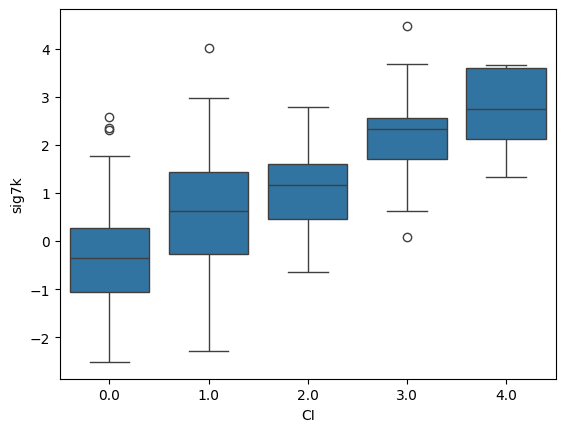

In [13]:
sns.boxplot(data=res, x='CI', y='sig7k')
plt.show()


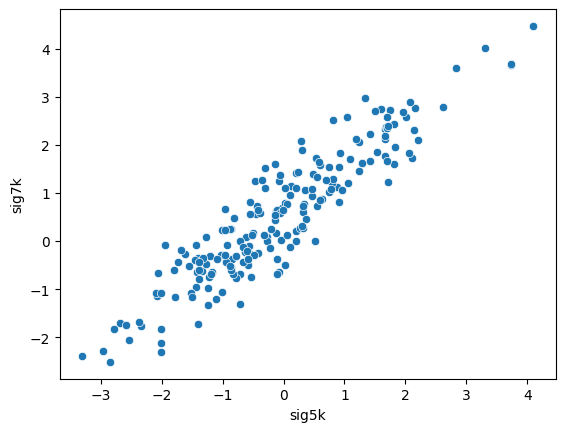

In [14]:
sns.scatterplot(data=res, x='sig5k', y='sig7k')
plt.show()


### Fig. 6b from Oh et. al.

In [32]:
#plot top protein weights
toplot = weightsdf_7k.sort_values("coef")
toplot = pd.concat([toplot.head(7), toplot.tail(7)])
toplot


,Symbol_unique,SeqId,coef,abs coef,intercept,mean,std_dev,assay,5k_to_7k_scale,11k_to_7k_scale
301,NPTXR.1,15511-37,-0.163950,0.163950,0.81812,3.071747,0.163952,7k,NaN,0.911
328,SEZ6L,19563-3,-0.145921,0.145921,0.81812,3.365302,0.085458,7k,NaN,0.923
506,NPTXR.2,8997-4,-0.114565,0.114565,0.81812,2.889503,0.158771,7k,NaN,1.158
289,CD93.2,14136-234,-0.098442,0.098442,0.81812,3.709828,0.087151,7k,NaN,0.912
335,TPPP3,20444-12,-0.094348,0.094348,0.81812,3.519203,0.130389,7k,NaN,1.381
525,PIANP.2,9599-6,-0.083814,0.083814,0.81812,3.201642,0.145868,7k,NaN,1.104
477,RNASE1,7211-2,-0.068670,0.068670,0.81812,3.250927,0.281949,7k,NaN,1.071
423,STC1,4930-21,0.068755,0.068755,0.81812,3.271929,0.116542,7k,NaN,0.963
324,CPLX1,18332-17,0.070053,0.070053,0.81812,2.344366,0.132582,7k,NaN,1.284
248,PTGDS,10514-5,0.070953,0.070953,0.81812,4.335063,0.139969,7k,NaN,1.224


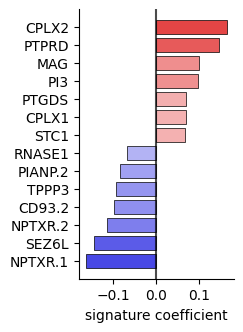

In [33]:
plt.figure(figsize=(2,3.5))
sns.barplot(data=tmp, x='coef', y='Symbol_unique', 
            hue='coef', hue_norm=(-0.2,0.2), palette='bwr', 
            legend=False,
            edgecolor='black', linewidth=0.5)
plt.axvline(0, color='black', alpha=0.7)
plt.ylim( -1, len(tmp),)
plt.xlabel("signature coefficient")
plt.ylabel("")
sns.despine()

plt.show()